# Tier 2. Module 4 - Deep Learning. Homework

## Lessons 5-6: Convolutional networks. Classification of images


This task solves the problem of image classification. You will work with the [Intel Image Classification](https://www.kaggle.com/datasets/puneet6060/intel-image-classification) dataset, which contains about 25,000 images of natural scenes from around the world, divided into 6 categories.

Your task is to design and train a deep learning model to classify images from the Intel Image Classification dataset. Each image is 150x150 pixels in size and belongs to one of 6 natural scene categories.


### 1. Import of the required libraries


In [1]:
import os
import random
from collections import defaultdict
from tqdm.autonotebook import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import cv2
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import models
import torchvision.datasets as D
import torchvision.transforms as T
import torch.nn.functional as F

from sklearn.metrics import balanced_accuracy_score, classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import warnings
# filter warnings
warnings.filterwarnings('ignore')

C:\Users\danie\AppData\Local\Temp\ipykernel_32152\3831121218.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### 2. Data preparation


#### 2.1. Dataset uploading


In [2]:
import kagglehub

# Download dataset and get the path
path = kagglehub.dataset_download("puneet6060/intel-image-classification")
print("Dataset downloaded to:", path)

Dataset downloaded to: C:\Users\danie\.cache\kagglehub\datasets\puneet6060\intel-image-classification\versions\2


In [3]:
train_dir = path + "\seg_train\seg_train"
test_dir = path + "\seg_test\seg_test"

In [4]:
train_dataset = D.ImageFolder(root=train_dir)
test_dataset = D.ImageFolder(root=test_dir)

#### 2.2. Display images examples


In [5]:
def count_samples(dataset):
    class_counts = {class_name: 0 for class_name in dataset.classes}
    for _, label in dataset.samples:
        class_name = dataset.classes[label]
        class_counts[class_name] += 1
    return class_counts

class_counts = count_samples(train_dataset)
print("Total samples in train dataset:", sum(class_counts.values()))

print("Number of samples in each class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Total samples in train dataset: 14034
Number of samples in each class:
buildings: 2191
forest: 2271
glacier: 2404
mountain: 2512
sea: 2274
street: 2382


In [6]:
test_class_counts = count_samples(test_dataset)
print("Total samples in test dataset:", sum(test_class_counts.values()))

print("Number of samples in each class:")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count}")

Total samples in test dataset: 3000
Number of samples in each class:
buildings: 437
forest: 474
glacier: 553
mountain: 525
sea: 510
street: 501


Displaying 4 samples from each class:

Class: buildings


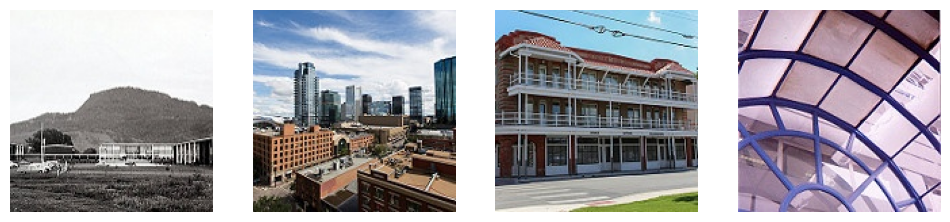

Class: forest


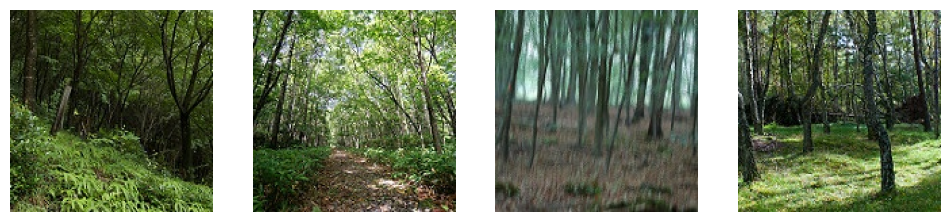

Class: glacier


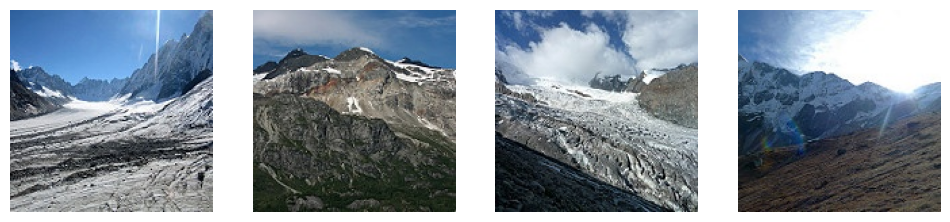

Class: mountain


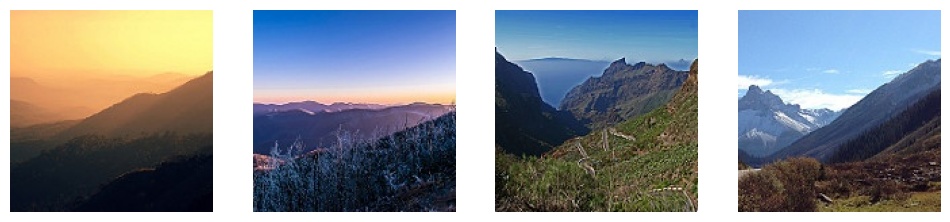

Class: sea


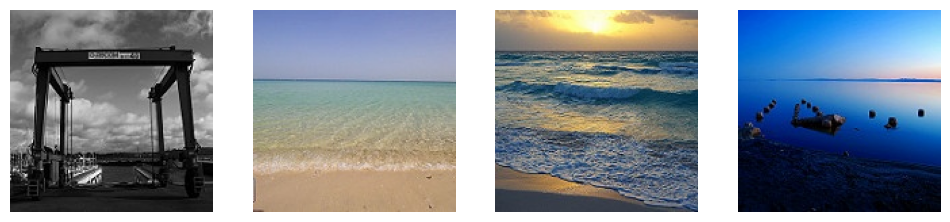

Class: street


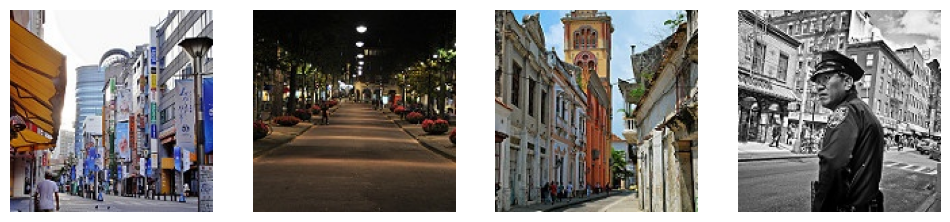

In [7]:
def display_samples(dataset, num_samples=4):
    class_to_images = {class_name: [] for class_name in dataset.classes}

    for image, label in dataset:
        class_name = dataset.classes[label]
        if len(class_to_images[class_name]) < num_samples:
            class_to_images[class_name].append(image)
        if all(len(images) >= num_samples for images in class_to_images.values()):
            break   # Stop if there are enough samples for each class

    for class_name, images in class_to_images.items():
        print(f"Class: {class_name}")
        fig, axes = plt.subplots(1, num_samples, figsize=(12, 3))
        for i, img in enumerate(images):
            axes[i].imshow(img)
            axes[i].axis('off')
        plt.show()

print("Displaying 4 samples from each class:\n")
display_samples(train_dataset)

Image shape (h, w, dim)


In [8]:
img, _ = train_dataset[0]
np.array(img).shape

(150, 150, 3)

#### 2.3. Pre-processing of images


In [9]:
base_size = 64

train_transform = T.Compose([
    T.Resize((base_size, base_size)),  # Resize images to base_size
    T.RandomHorizontalFlip(),  # Randomly flip image horizontally
    T.ToTensor(),  # Transform it into a PyTorch Tensor
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalization to speed up the computations
])

test_transform = T.Compose([
    T.Resize((base_size, base_size)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = D.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = D.ImageFolder(root=test_dir, transform=test_transform)

#### 2.4. Train, test and validation split


In [10]:
train_subset, validation_subset = train_test_split(
    train_dataset, test_size=0.2, random_state=42
)

print("Test dataset:      ", len(train_subset), "samples")
print("Validation dataset:", len(validation_subset), " samples")
print("Test dataset:      ", len(test_dataset), " samples")

Test dataset:       11227 samples
Validation dataset: 2807  samples
Test dataset:       3000  samples


#### 2.5. Data loaders


In [12]:
batch_size = 32

train_dataloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=8)
validation_dataloader = DataLoader(validation_subset, batch_size=batch_size, shuffle=False, num_workers=1)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

Check the data loaders


In [13]:
data_iter = iter(train_dataloader)
images, labels = next(data_iter)

print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")

Image batch shape: torch.Size([32, 3, 64, 64])
Label batch shape: torch.Size([32])


### 3. Custom CNN model


In [47]:
class BaselineModel(nn.Module):

    def __init__(self, ): 
        super().__init__()
        self.num_channels = 32
        
        # each of the convolution layers below have the arguments (input_channels, output_channels, filter_size,
        # stride, padding). We also include batch normalisation layers that help stabilise training.

        self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)

        # 2 fully connected layers to transform the output of the convolution layers to the final output
        self.fc1 = nn.Linear(8*8*self.num_channels*4, self.num_channels*4)
        self.fc2 = nn.Linear(self.num_channels*4, 6)       

    def forward(self, s):
        #                                                  -> batch_size x 3 x 64 x 64
        # we apply the convolution layers, followed by batch normalisation, maxpool and relu x 3
        s = self.conv1(s)                                   # batch_size x num_channels x 64 x 64
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels x 32 x 32
        s = self.conv2(s)                                   # batch_size x num_channels*2 x 32 x 32
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels*2 x 16 x 16
        s = self.conv3(s)                                   # batch_size x num_channels*4 x 16 x 16
        s = F.relu(F.max_pool2d(s, 2))                      # batch_size x num_channels*4 x 8 x 8

        # flatten the output for each image
        s = s.view(-1, 8*8*self.num_channels*4)             # batch_size x 8*8*num_channels*4

        # apply 2 fully connected layers with dropout
        s = F.relu(self.fc1(s))                             # batch_size x self.num_channels*4
        s = self.fc2(s)                                     # batch_size x 6

        # apply log softmax on each image's output (this is recommended over applying softmax
        # since it is numerically more stable)
        return F.log_softmax(s, dim=1)

In [14]:
cuda = torch.cuda.is_available()  

# Set the random seed for reproducible experiments
torch.manual_seed(42)
if cuda:
    cuda.manual_seed(42)

# Specify a computing device
device = "cuda" if cuda else "cpu"

In [49]:
cnn_model = BaselineModel().to(device)
cnn_model

BaselineModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

### 4. Pre-trained model

EfficientNet_b0 pretrained model is used in this task for a good balance between accuracy and computational efficiency.

To avoid retraining the model, we will freeze the pre-trained layers and only replace the classifier, making it suitable for 6-class classification.

In [16]:
efficientnet_b0_frozen = models.efficientnet_b0(pretrained=True)

# for param in efficientnet_b0_frozen.features.parameters():
for param in efficientnet_b0_frozen.parameters():
    param.requires_grad = False # Freeze all pre-trained layers

num_features = efficientnet_b0_frozen.classifier[1].in_features    # New 6-class classifier
efficientnet_b0_frozen.classifier[1] = nn.Linear(num_features, len(train_dataset.classes))

efficientnet_b0_frozen = efficientnet_b0_frozen.to(device)
efficientnet_b0_frozen

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 5. Definition of loss function and optimizer

CrossEntropyLoss is used in this task as loss function, because it's designed for multi-class classification, where the model predicts probabilities for multiple classes, and the goal is to assign the highest probability to the correct class.

In [19]:
criterion = nn.CrossEntropyLoss().to(device)

In [20]:
efficientnet_optimizer_frozen = torch.optim.Adam(efficientnet_b0_frozen.parameters(), lr=0.001)

In [ ]:
cnn_model_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

### 6. Custom model training

In [27]:
def train_model(model, criterion, optimizer, path, num_epochs = 10):
    best_validation_acc = 0.0

    train_losses = []
    train_accs = []

    validation_losses = []
    validation_accs = []

    for epoch in tqdm(range(num_epochs)):
        
        # Train step
        
        model.train()
        
        train_epoch_loss = []
        train_epoch_acc = []
        
        for i, (train_batch, labels_batch) in tqdm(enumerate(train_dataloader)):
            if cuda:
                train_batch, labels_batch = train_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)

            # compute model output and loss
            output_batch = model(train_batch)

            loss = criterion(output_batch, labels_batch)

            # clear previous gradients, compute gradients of all variables wrt loss
            optimizer.zero_grad()
            loss.backward()

            # performs updates using calculated gradients
            optimizer.step()
            
            batch_loss = loss.cpu().detach().numpy()
            batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
                                                labels_batch.cpu().detach().numpy())
            
            train_epoch_loss.append(batch_loss)
            train_epoch_acc.append(batch_acc)
            
        
        avg_train_loss = np.mean(train_epoch_loss)
        avg_train_acc = np.mean(train_epoch_acc)
        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)
        print(f"Train epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f}")
        
        # Eval step
        
        model.eval()
        
        validation_epoch_loss = []
        validation_epoch_acc = []
        
        with torch.no_grad():
            
            for i, (validation_batch, labels_batch) in enumerate(validation_dataloader):
                if cuda:
                    validation_batch, labels_batch = validation_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)

                # compute model output and loss
                output_batch = model(validation_batch)

                loss = criterion(output_batch, labels_batch)

                batch_loss = loss.cpu().detach().numpy()
                batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
                                                    labels_batch.cpu().detach().numpy())

                validation_epoch_loss.append(batch_loss)
                validation_epoch_acc.append(batch_acc)

        avg_validation_loss = np.mean(validation_epoch_loss)
        avg_validation_acc = np.mean(validation_epoch_acc)
        validation_losses.append(avg_validation_loss)
        validation_accs.append(avg_validation_acc)
        print(f"Validation epoch [{epoch+1}/{num_epochs}], Loss: {avg_validation_loss:.4f}, Acc: {avg_validation_acc:.4f}")
        
        # Save the model if validation accuracy improves
        if avg_validation_acc > best_validation_acc:
            best_validation_acc = avg_validation_acc
            torch.save(model.state_dict(), path)
            print(f"New best model saved with validation accuracy: {best_validation_acc:.4f}")

    print(f"Training complete. Best validation accuracy: {best_validation_acc:.4f}. Model saved at: {path}")

    return train_losses, validation_losses, train_accs, validation_accs

In [53]:
best_cnn_model_path = "./didactic/data/best_cnn_model.pth"

cnn_metrics = train_model(cnn_model, criterion, cnn_model_optimizer, best_cnn_model_path)

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train epoch [1/10], Loss: 1.0111, Acc: 0.6258
Validation epoch [1/10], Loss: 0.9203, Acc: 0.7124
New best model saved with validation accuracy: 0.7124


0it [00:00, ?it/s]

Train epoch [2/10], Loss: 0.7148, Acc: 0.7498
Validation epoch [2/10], Loss: 0.6930, Acc: 0.7427
New best model saved with validation accuracy: 0.7427


0it [00:00, ?it/s]

Train epoch [3/10], Loss: 0.5783, Acc: 0.8018
Validation epoch [3/10], Loss: 0.5841, Acc: 0.7944
New best model saved with validation accuracy: 0.7944


0it [00:00, ?it/s]

Train epoch [4/10], Loss: 0.4823, Acc: 0.8362
Validation epoch [4/10], Loss: 0.5711, Acc: 0.7964
New best model saved with validation accuracy: 0.7964


0it [00:00, ?it/s]

Train epoch [5/10], Loss: 0.3958, Acc: 0.8609
Validation epoch [5/10], Loss: 0.5493, Acc: 0.8127
New best model saved with validation accuracy: 0.8127


0it [00:00, ?it/s]

Train epoch [6/10], Loss: 0.3147, Acc: 0.8907
Validation epoch [6/10], Loss: 0.5781, Acc: 0.8069


0it [00:00, ?it/s]

Train epoch [7/10], Loss: 0.2484, Acc: 0.9136
Validation epoch [7/10], Loss: 0.6400, Acc: 0.7985


0it [00:00, ?it/s]

Train epoch [8/10], Loss: 0.1728, Acc: 0.9425
Validation epoch [8/10], Loss: 0.7869, Acc: 0.7926


0it [00:00, ?it/s]

Train epoch [9/10], Loss: 0.1136, Acc: 0.9610
Validation epoch [9/10], Loss: 0.8624, Acc: 0.8048


0it [00:00, ?it/s]

Train epoch [10/10], Loss: 0.0911, Acc: 0.9689
Validation epoch [10/10], Loss: 0.9228, Acc: 0.7983
Training complete. Best validation accuracy: 0.8127. Model saved at: ./didactic/data/best_cnn_model.pth


### 7. Custom model evaluation

In this dataset, all classes are fairly balanced, so regular accuracy would be sufficient to estimate accuracy. However, we will use Balanced Accuracy and the F1-Score metrics, which are more general and characterize the performance of the model even if it has to deal with unbalanced data for classification in the future.

In [22]:
def test_model(best_model):
    best_model.eval()

    # Placeholders for predictions and true labels
    all_preds = []
    all_labels = []

    # Evaluate on the test dataset
    with torch.no_grad():
        for test_batch, labels_batch in test_dataloader:
            test_batch, labels_batch = test_batch.to(device), labels_batch.to(device)
            
            outputs = best_model(test_batch)
            _, preds = torch.max(outputs, 1)  # Get predicted class indices
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate metrics
    accuracy = balanced_accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')  # Weighted average accounts for class imbalance
    classification_rep = classification_report(all_labels, all_preds, target_names=test_dataset.classes)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print("\nClassification Report:\n", classification_rep)
    
    return all_labels, all_preds

In [65]:
best_cnn_model = BaselineModel().to(device)
best_cnn_model.load_state_dict(torch.load(best_cnn_model_path))

cnn_predictions = test_model(best_cnn_model)

Test Accuracy: 0.8131
Test F1 Score: 0.8114

Classification Report:
               precision    recall  f1-score   support

   buildings       0.77      0.77      0.77       437
      forest       0.89      0.95      0.92       474
     glacier       0.78      0.78      0.78       553
    mountain       0.79      0.78      0.79       525
         sea       0.79      0.83      0.81       510
      street       0.84      0.77      0.81       501

    accuracy                           0.81      3000
   macro avg       0.81      0.81      0.81      3000
weighted avg       0.81      0.81      0.81      3000



### 8. Custom model results analysis

#### 8.1. Learning curves

In [23]:
def print_metrics(train_metric, validation_metric, name):
    plt.figure(figsize=(4, 3))
    plt.plot(train_metric, label='Train')
    plt.plot(validation_metric, label='Validation')
    plt.legend(loc='best')
    plt.xlabel('Epochs')
    plt.ylabel(name)
    plt.title('Training vs Validation Metric')
    plt.show()

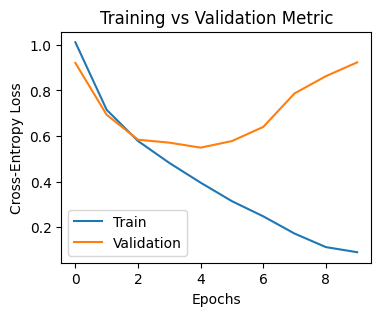

In [60]:
print_metrics(cnn_metrics[0], cnn_metrics[1], "Cross-Entropy Loss")

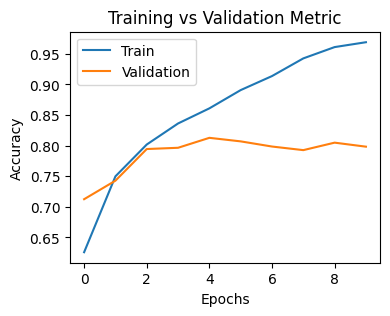

In [61]:
print_metrics(cnn_metrics[2], cnn_metrics[3], "Accuracy")

As can be seen from the learning curves, the model began to overoverfeat train after the 6th epoch, so the early stopping method was applied and the model with the best parameters on the validation dataset was saved.

#### 8.2. Confusion matrix

In [24]:
def print_confusion_matrix(labels, predictions):
    cm = confusion_matrix(labels, predictions)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)

    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, cmap="Blues", values_format='d')  # 'd' for integer formatting
    plt.title("Confusion Matrix")
    plt.show()

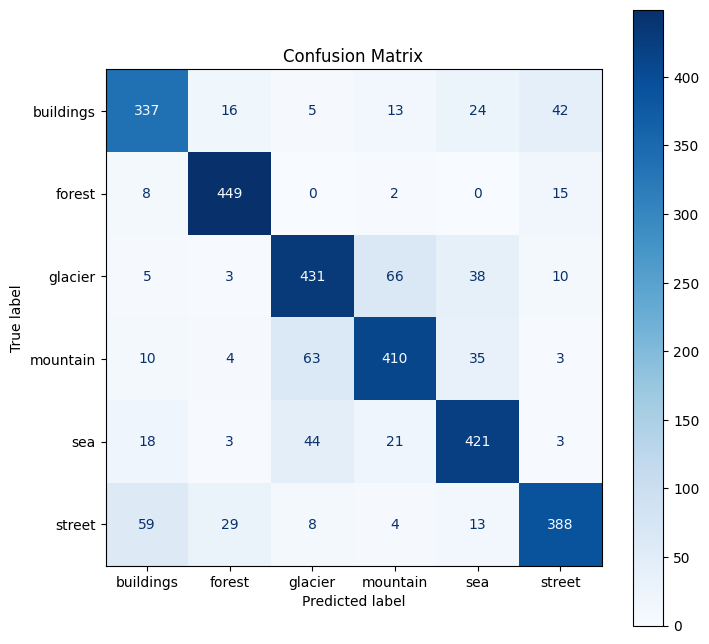

In [68]:
print_confusion_matrix(cnn_predictions[0], cnn_predictions[1])

As can be seen from the confusion matrix, our model has the most problems with classifying glaciers and mountains (which is understandable, because many glaciers are located in mountains), as well as streets and houses (which are also often complementary things).

### 9. Transfer learning

In [28]:
best_frozen_transfer_model_path = "./didactic/data/best_efficientnet_b0_frozen.pth"

eff_frozen_metrics = train_model(efficientnet_b0_frozen, criterion, efficientnet_optimizer_frozen, best_frozen_transfer_model_path)

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train epoch [1/10], Loss: 0.7742, Acc: 0.7155
Validation epoch [1/10], Loss: 0.7493, Acc: 0.7225
New best model saved with validation accuracy: 0.7225


0it [00:00, ?it/s]

Train epoch [2/10], Loss: 0.7816, Acc: 0.7145
Validation epoch [2/10], Loss: 0.7528, Acc: 0.7196


0it [00:00, ?it/s]

Train epoch [3/10], Loss: 0.7849, Acc: 0.7103
Validation epoch [3/10], Loss: 0.7704, Acc: 0.7074


0it [00:00, ?it/s]

Train epoch [4/10], Loss: 0.7726, Acc: 0.7173
Validation epoch [4/10], Loss: 0.7577, Acc: 0.7274
New best model saved with validation accuracy: 0.7274


0it [00:00, ?it/s]

Train epoch [5/10], Loss: 0.7707, Acc: 0.7144
Validation epoch [5/10], Loss: 0.7493, Acc: 0.7270


0it [00:00, ?it/s]

Train epoch [6/10], Loss: 0.7744, Acc: 0.7125
Validation epoch [6/10], Loss: 0.7679, Acc: 0.7250


0it [00:00, ?it/s]

Train epoch [7/10], Loss: 0.7694, Acc: 0.7204
Validation epoch [7/10], Loss: 0.7427, Acc: 0.7151


0it [00:00, ?it/s]

Train epoch [8/10], Loss: 0.7816, Acc: 0.7135
Validation epoch [8/10], Loss: 0.7538, Acc: 0.7263


0it [00:00, ?it/s]

Train epoch [9/10], Loss: 0.7723, Acc: 0.7172
Validation epoch [9/10], Loss: 0.7645, Acc: 0.7166


0it [00:00, ?it/s]

Train epoch [10/10], Loss: 0.7738, Acc: 0.7155
Validation epoch [10/10], Loss: 0.7624, Acc: 0.7219
Training complete. Best validation accuracy: 0.7274. Model saved at: ./didactic/data/best_efficientnet_b0_frozen.pth


### 10. Transfer model evaluation

In [29]:
best_eff_frozen_model = models.efficientnet_b0(pretrained=False)
num_eff_frozen_features = best_eff_frozen_model.classifier[1].in_features
best_eff_frozen_model.classifier[1] = nn.Linear(num_eff_frozen_features, 6)
best_eff_frozen_model.load_state_dict(torch.load(best_frozen_transfer_model_path))
best_eff_frozen_model = best_eff_frozen_model.to(device)

eff_frozen_predictions = test_model(best_eff_frozen_model)

Test Accuracy: 0.7238
Test F1 Score: 0.7201

Classification Report:
               precision    recall  f1-score   support

   buildings       0.77      0.71      0.74       437
      forest       0.91      0.92      0.91       474
     glacier       0.62      0.63      0.63       553
    mountain       0.62      0.66      0.64       525
         sea       0.71      0.66      0.68       510
      street       0.72      0.77      0.74       501

    accuracy                           0.72      3000
   macro avg       0.73      0.72      0.72      3000
weighted avg       0.72      0.72      0.72      3000



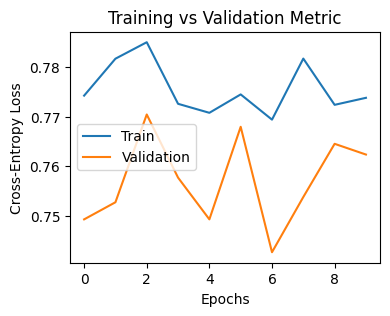

In [30]:
print_metrics(eff_frozen_metrics[0], eff_frozen_metrics[1], "Cross-Entropy Loss")

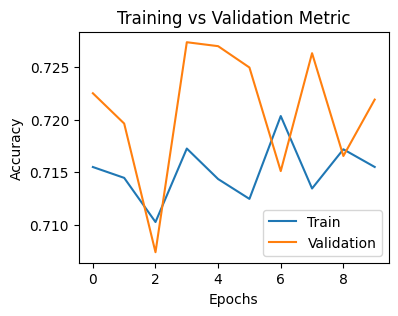

In [31]:
print_metrics(eff_frozen_metrics[2], eff_frozen_metrics[3], "Accuracy")

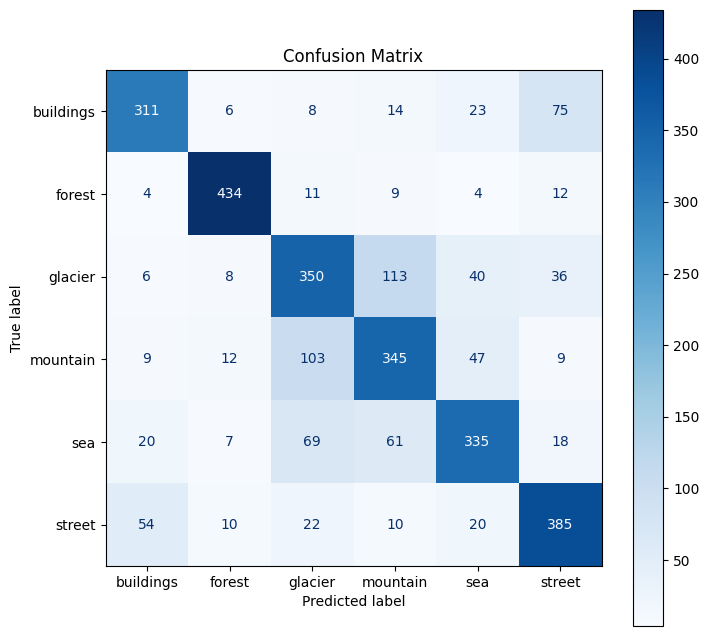

In [34]:
print_confusion_matrix(eff_frozen_predictions[0], eff_frozen_predictions[1])

This model with frozen layers showed unsatisfactory classification results. Let's try to improve it.

### 11. Results improvement

Let's try to completely retrain all layers the pre-trained model to get better accuracy.

In [ ]:
efficientnet_b0 = models.efficientnet_b0(pretrained=True)

num_features = efficientnet_b0.classifier[1].in_features
efficientnet_b0.classifier[1] = nn.Linear(num_features, len(train_dataset.classes))

efficientnet_b0 = efficientnet_b0.to(device)
efficientnet_b0

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
efficientnet_optimizer = torch.optim.Adam(efficientnet_b0.parameters(), lr=0.001)

In [72]:
best_transfer_model_path = "./didactic/data/best_efficientnet_b0.pth"

eff_metrics = train_model(efficientnet_b0, criterion, efficientnet_optimizer, best_transfer_model_path)

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train epoch [1/10], Loss: 0.1074, Acc: 0.9582
Validation epoch [1/10], Loss: 0.4091, Acc: 0.8997
New best model saved with validation accuracy: 0.8997


0it [00:00, ?it/s]

Train epoch [2/10], Loss: 0.0863, Acc: 0.9659
Validation epoch [2/10], Loss: 0.3564, Acc: 0.9029
New best model saved with validation accuracy: 0.9029


0it [00:00, ?it/s]

Train epoch [3/10], Loss: 0.0809, Acc: 0.9656
Validation epoch [3/10], Loss: 0.3881, Acc: 0.9147
New best model saved with validation accuracy: 0.9147


0it [00:00, ?it/s]

Train epoch [4/10], Loss: 0.0636, Acc: 0.9756
Validation epoch [4/10], Loss: 0.4247, Acc: 0.8848


0it [00:00, ?it/s]

Train epoch [5/10], Loss: 0.0756, Acc: 0.9707
Validation epoch [5/10], Loss: 0.3972, Acc: 0.8977


0it [00:00, ?it/s]

Train epoch [6/10], Loss: 0.0695, Acc: 0.9716
Validation epoch [6/10], Loss: 0.3859, Acc: 0.8990


0it [00:00, ?it/s]

Train epoch [7/10], Loss: 0.0565, Acc: 0.9757
Validation epoch [7/10], Loss: 0.4860, Acc: 0.8815


0it [00:00, ?it/s]

Train epoch [8/10], Loss: 0.0478, Acc: 0.9806
Validation epoch [8/10], Loss: 0.3980, Acc: 0.9040


0it [00:00, ?it/s]

Train epoch [9/10], Loss: 0.0533, Acc: 0.9776
Validation epoch [9/10], Loss: 0.5293, Acc: 0.8950


0it [00:00, ?it/s]

Train epoch [10/10], Loss: 0.0768, Acc: 0.9707
Validation epoch [10/10], Loss: 0.4547, Acc: 0.9035
Training complete. Best validation accuracy: 0.9147. Model saved at: ./didactic/data/best_cnn_model.pth


#### 12. Retrained model evaluation

In [73]:
best_eff_model = models.efficientnet_b0(pretrained=False)
num_eff_features = best_eff_model.classifier[1].in_features
best_eff_model.classifier[1] = nn.Linear(num_eff_features, 6)
best_eff_model.load_state_dict(torch.load(best_transfer_model_path))
best_eff_model = best_eff_model.to(device)

eff_predictions = test_model(best_eff_model)

Test Accuracy: 0.9020
Test F1 Score: 0.8989

Classification Report:
               precision    recall  f1-score   support

   buildings       0.89      0.91      0.90       437
      forest       0.98      0.97      0.98       474
     glacier       0.91      0.77      0.83       553
    mountain       0.79      0.91      0.84       525
         sea       0.92      0.94      0.93       510
      street       0.94      0.91      0.93       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



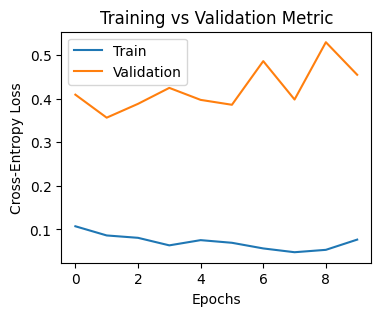

In [75]:
print_metrics(eff_metrics[0], eff_metrics[1], "Cross-Entropy Loss")

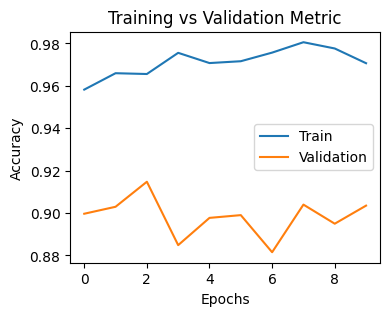

In [76]:
print_metrics(eff_metrics[2], eff_metrics[3], "Accuracy")

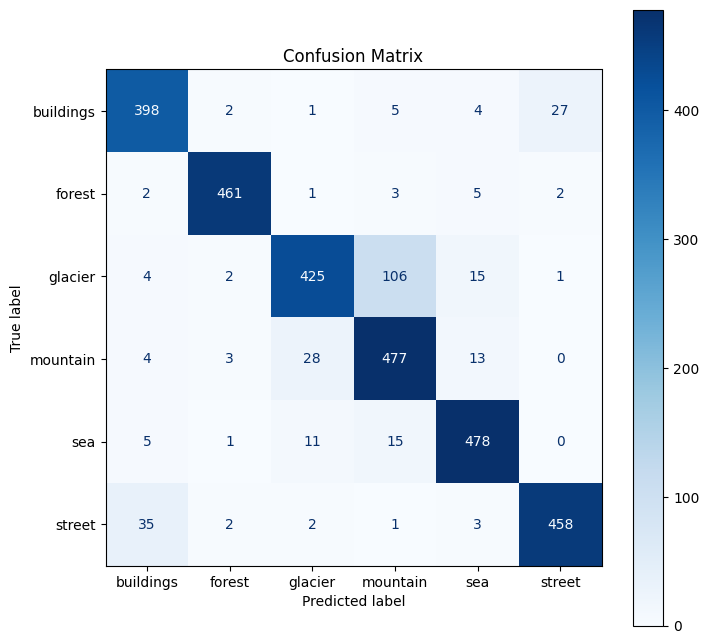

In [77]:
print_confusion_matrix(eff_predictions[0], eff_predictions[1])

Complete retraining of the simplest of the EfficientNet models allowed us to obtain accuracy and f1-score at the level of 90%. EfficientNet_b0 model was able to distinguish houses from streets much better, but it still had problems distinguishing glaciers from mountains. To further improve the model, more complex versions could be taken, such as EfficientNet_b7.